<a href="https://colab.research.google.com/github/JasonThMdl/Thesis/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
import pandas as pd
from matplotlib import animation, rc
plt.rcParams.update({'pdf.fonttype': 'truetype'})
import math
import random
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


In [ ]:
# Visualization functions

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label

output_notebook()

def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c = 'blue', alpha = 1.00, linewidth = 1)
    plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(fig_number);
    plt.xlabel("Time step");
    plt.ylabel("Price ($)");
    plt.xticks(range(T))
    plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
    return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.5, linewidth=2)

def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    stack_data = np.stack(data[:,2])

    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    for idx, item in enumerate(data):

        if len(data) > 1:
            ax = axarr[idx]

        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h, color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)
            
    if bar_label is not None:
        rect = rects[0]
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width(),
            -height * .1,
            bar_label,
            ha='center',
            va='bottom',
            color='white')
    if axis_label:
        ax.set_xlabel(axis_label)
    fig.subplots_adjust(hspace=0)

In [ ]:
price_grid = np.arange(25.138111764705883, 34,0.25)
T=6
unit_cost=0.8*25.138111764705883
forecasts=[187,174,186,185,225,184,176,169,160,157,144,159,146,151,142,149,144,144,139,137]
#elasticity=-10.121471663367464
elasticity=-10


def profit_t_response(p_t, p_t_1):
    return profit_t(p_t, p_t_1, elasticity,forecasted_sales_t)

def profit_t(p_t, p_t_1, elsticity,forecasted_sales_t):
    #print(p_t,p_t-1,q_t(p_t, p_t_1,elasticity,forecasted_sales_t),(p_t - unit_cost) )
    return q_t(p_t, p_t_1,elasticity,forecasted_sales_t)*(p_t - unit_cost) 

def q_t(p_t, p_t_1,elasticity,forecasted_sales_t):
    #print(forecasted_sales_t*(p_t/p_t_1)**elasticity,forecasted_sales_t,p_t,p_t_1,elasticity,p_t)
    return forecasted_sales_t*(p_t/p_t_1)**elasticity

def profit_total(p, unit_cost, q_0, k, a, b):
    return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))
    
def profit_response(p):
    return profit_total(p, unit_cost, q_0, k, a_q, b_q)


Episode 980 of 1000 (98.00%)


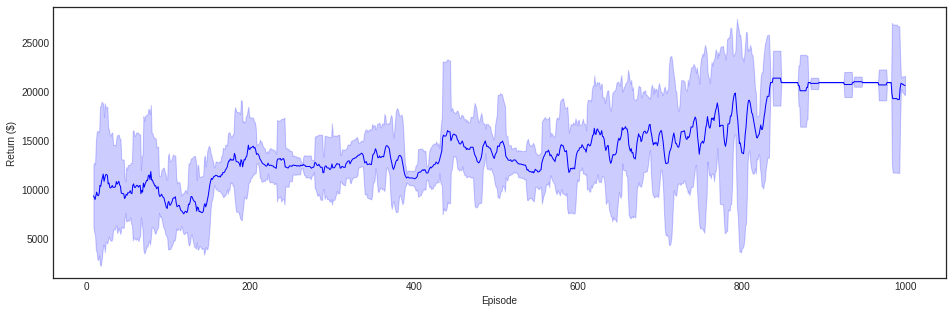

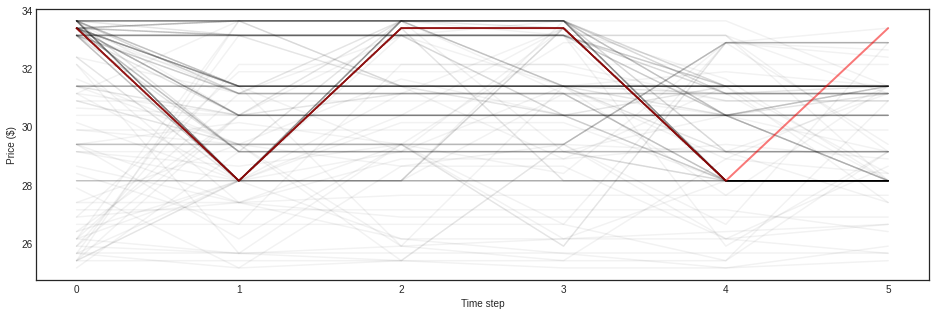

In [ ]:

# A cyclic buffer of bounded size that holds the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetworkDQN, self).__init__()
        layers = [
              nn.Linear(state_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, action_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        q_values = self.model(x)
        return q_values  

class AnnealedEpsGreedyPolicy(object):
    def __init__(self, eps_start = 0.9, eps_end = 0.01, eps_decay = 400):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps_done = 0

    def select_action(self, q_values):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            return np.argmax(q_values)
        else:
            dont_be_greedy=action
            if action>len(price_grid)-5:
              dont_be_greedy=len(price_grid)-5
            return random.randrange(0,dont_be_greedy+4)

GAMMA = 0.8
TARGET_UPDATE = 20
BATCH_SIZE = 512

def update_model(memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)  

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def env_intial_state():
    a=np.repeat(0, 2*T)
    a[0]=27
    return a

def env_step(t, state, action):
    next_state = np.repeat(0, len(state))
    next_state[0] = price_grid[action]
    next_state[1:T] = state[0:T-1]
    #print(next_state)
    next_state[T+t] = 1
    #print(next_state)
    reward = profit_t_response(next_state[0], next_state[1])
    #print(next_state)
    return next_state, reward

def to_tensor(x):
    return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
    return torch.tensor([[x]], device=device, dtype=torch.long)

policy_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
target_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr = 0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayMemory(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 1000
return_trace = []
p_trace = [] # price schedules used in each episode
for i_episode in range(num_episodes):
    state = env_intial_state()
    #print(state)
    reward_trace = []
    p = []
    q=[]
    for t in range(T): 
        forecasted_sales_t=forecasts[t]#############
        # Select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())
        next_state, reward = env_step(t, state, action)

        # Store the transition in memory
        memory.push(to_tensor(state), 
                    to_tensor_long(action), 
                    to_tensor(next_state) if t != T - 1 else None, 
                    to_tensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_grid[action])
        #q.append(q_t(p_t, p_t_1,elasticity,forecasted_sales_t))

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait = True)
        print(f'Episode {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)')



plot_return_trace(return_trace)

fig = plt.figure(figsize=(16, 5))
plot_price_schedules(p_trace, 5, 1, fig.number)



In [ ]:
p_trace

In [ ]:
def select_action(self, q_values):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            return np.argmax(q_values)
        else:
            return random.randrange(len(q_values))


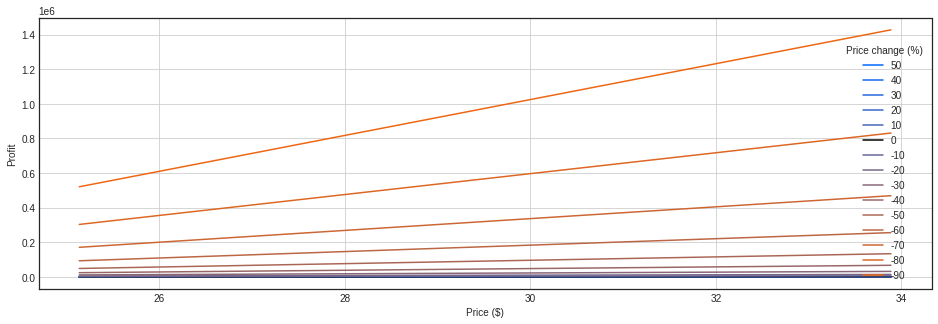

In [ ]:
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )
for i in range(len(price_grid)):
    for j in range(len(price_change_grid)):
        profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i]*price_change_grid[j])

plt.figure(figsize=(16, 5))
for i in range(len(price_change_grid)):
    if math.isclose(price_change_grid[i], 1.0):
        color = 'black'
    else:
        p_norm = (price_change_grid[i]-0.5)/1.5
        color = (p_norm, 0.4, 1 - p_norm)
    plt.plot(price_grid, profit_map[:, i], c=color)
plt.xlabel("Price ($)")
plt.ylabel("Profit")
plt.legend(np.int_(np.round((1-price_change_grid)*100)), loc='lower right', title="Price change (%)", fancybox=False, framealpha=0.6)
plt.grid(True)

In [ ]:
profit_t_response(price_grid[0], price_grid[0]*price_change_grid[14])


103615.01975683674 169 25.138111764705883 47.76241235294117 -10
25.138111764705883 24.138111764705883 103615.01975683674 5.027622352941176
103615.01975683674 169 25.138111764705883 47.76241235294117 -10


520937.189429914

In [ ]:
state

array([25, 27,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0])